# Définition du projet

 - régimes alimentaires de chaque pays
 - en termes de protéines d'origine animale
 - en termes de calories

Construire l'échantillon contenant l'ensemble des pays disponibles

Variables:
- différence de population entre une année antérieure (au choix) et l'année courante, exprimée en pourcentage 
- proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la disponibilité alimentaire du pays 
- disponibilité alimentaire en protéines par habitant 
- disponibilité alimentaire en calories par habitant
- PIB par habitant

# Recupération des csv

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import datetime 
from sklearn import decomposition
from sklearn import preprocessing
from functions import *
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.stats import norm

In [2]:
# fonction clé primaire
def test_primary_key(df, column):
        if len(df) == len(df[column].drop_duplicates()):
                print("la clé  est unique")
        else : print('la clé n est pas unique')
        print('___')

#fonction is_null
def test_is_null(df):
    print(df.isnull().sum())
    print('___')

In [3]:
df_bilan_alim_2017 = pd.read_csv('FAOSTAT_data_fr_7-13-2022.csv')
df_prot_animales_raw = pd.read_csv('FAOSTAT_data_fr_8-5-2022.csv')

population_2012 = pd.read_csv('FAOSTAT_annual_population_2012.csv')
population_2017 = pd.read_csv('FAOSTAT_annual_population_2017.csv')

df_pib_pop = pd.read_csv('FAOSTAT_data_fr_8-3-2022.csv')

## Objectifs à court terme :

- différence de population entre une année antérieure (au choix) et l'année courante, exprimée en - pourcentage ;
- proportion de protéines d'origine animale par rapport à la quantité totale de protéines dans la  - - disponibilité alimentaire du pays
- disponibilité alimentaire en protéines par habitant
- disponibilité alimentaire en calories par habitant

# On drop les colonnes qui ne servent à rien, puis on met la popualtion en millions

In [4]:
population_2017['Valeur'] *= 1000
population_2012['Valeur'] *= 1000
population_2017.drop(columns=['Code Domaine', 'Année', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Élément', 'Code Produit', 'Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note'], inplace=True)
population_2012.drop(columns=['Code Domaine', 'Année', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Élément', 'Code Produit', 'Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note'], inplace=True)

In [5]:
df_pib_pop.drop(columns=['Domaine', 'Année','Code Domaine', 'Code zone (FAO)', 'Code Élément', 'Élément', 'Code Produit', 'Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note'], inplace=True)
df_pib_pop = df_pib_pop.rename(columns={"Valeur": "Pib_dollar_parHab"})

# Différence de population entre une année antérieure (au choix) et l'année courante, exprimée en - pourcentage


In [6]:
df_population_2017 = population_2017.copy()
df_population_2017['Difference_pop'] = population_2017['Valeur'] - population_2012['Valeur']
df_population_2017['Difference_pop_pourcentage'] = ((population_2017['Valeur'] - population_2012['Valeur'])/population_2012['Valeur'])*100
#df_population_2017.drop(columns='Valeur', inplace=True)

df_population_2017

,Zone,Valeur,Difference_pop,Difference_pop_pourcentage
0,Afghanistan,36296113.0,5134737.0,16.477889
1,Afrique du Sud,57009756.0,4177098.0,7.906280
2,Albanie,2884169.0,-29927.0,-1.026974
3,Algérie,41389189.0,4005294.0,10.713956
4,Allemagne,82658409.0,1685781.0,2.081915
...,...,...,...,...
232,Venezuela (République bolivarienne du),29402484.0,41647.0,0.141845
233,Viet Nam,94600648.0,4798722.0,5.343674
234,Yémen,27834819.0,3361641.0,13.736022
235,Zambie,16853599.0,2388449.0,16.511747


# Dispo alimentaire par habitant et proportion de protéines d'origine animale

In [7]:
#Je veux isoler les colonnes Afghanistan pour voir ce que l'on a comme Elements dans chaque pays
df2 = df_bilan_alim_2017.loc[df_bilan_alim_2017['Zone'].isin(['Afghanistan']), :]
#df2
#df2['Élément'].to_list()

Les éléments qui ressortent et nous intéressent

'Disponibilité alimentaire en quantité (kg/personne/an)',
 'Disponibilité alimentaire (Kcal/personne/jour)',
 'Disponibilité de protéines en quantité (g/personne/jour)',
 'Disponibilité de matière grasse en quantité (g/personne/jour)

In [8]:
df_dispo_alim_quantite = df_bilan_alim_2017.loc[df_bilan_alim_2017['Élément'].isin(['Disponibilité alimentaire en quantité (kg/personne/an)'])].copy()
df_dispo_alim_quantite.head(1)

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
12,FBS,Bilans Alimentaires (2010-),2,Afghanistan,645,Disponibilité alimentaire en quantité (kg/pers...,2511,Blé et produits,2017,2017,kg,163.76,Fc,Donnée calculée


In [9]:
df_dispo_prot_quantite = df_bilan_alim_2017.loc[df_bilan_alim_2017['Élément'].isin(['Disponibilité de protéines en quantité (g/personne/jour)'])].copy()
#On harmonise avec la dispo en quantité, on met tout en g/personne/an
df_dispo_prot_quantite['Valeur'] *= 365
df_dispo_prot_quantite['Unité'] = 'g/personne/an'
df_dispo_prot_quantite.head(2)

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
14,FBS,Bilans Alimentaires (2010-),2,Afghanistan,674,Disponibilité de protéines en quantité (g/pers...,2511,Blé et produits,2017,2017,g/personne/an,13793.35,Fc,Donnée calculée
28,FBS,Bilans Alimentaires (2010-),2,Afghanistan,674,Disponibilité de protéines en quantité (g/pers...,2807,Riz et produits,2017,2017,g/personne/an,1255.60,Fc,Donnée calculée


In [10]:
df_dispo_prot_quantite.drop(columns=['Code Domaine', 'Année', 'Unité', 'Élément', 'Produit', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Code Produit', 'Code année', 'Symbole', 'Description du Symbole'], inplace=True)
df_dispo_prot_quantite.head

<bound method NDFrame.head of                Zone    Valeur
14      Afghanistan  13793.35
28      Afghanistan   1255.60
42      Afghanistan    160.60
57      Afghanistan     87.60
67      Afghanistan      0.00
...             ...       ...
186472     Zimbabwe      0.00
186480     Zimbabwe      0.00
186488     Zimbabwe      0.00
186498     Zimbabwe      0.00
186508     Zimbabwe     10.95

[15348 rows x 2 columns]>

In [11]:
df_dispo_prot_quantite = df_dispo_prot_quantite.groupby(['Zone']).sum().reset_index()
df_dispo_prot_quantite = df_dispo_prot_quantite.rename(columns={"Valeur": "Dispo_prot_quantite_g_personne_an"})
#attention, je rename la column là. Si je l'appelle après sans l'avoir modifiée dans les fonctions d'appel
#je risque d'avoir des erreurs

df_dispo_prot_quantite

,Zone,Dispo_prot_quantite_g_personne_an
0,Afghanistan,21721.15
1,Afrique du Sud,29083.20
2,Albanie,41858.20
3,Algérie,32335.35
4,Allemagne,37894.30
...,...,...
175,Émirats arabes unis,29981.10
176,Équateur,22907.40
177,États-Unis d'Amérique,41281.50
178,Éthiopie,26816.55


In [12]:
df_dispo_alim_quantite.drop(columns=['Code Domaine','Unité', 'Année', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Code Produit', 'Code année', 'Symbole', 'Description du Symbole'], inplace=True)
df_dispo_alim_quantite = df_dispo_alim_quantite.groupby(['Zone']).sum().reset_index()

df_dispo_alim_quantite = df_dispo_alim_quantite.rename(columns={"Valeur": "Dispo_alim_quantite_kg_personne_an"})
df_dispo_alim_quantite

,Zone,Dispo_alim_quantite_kg_personne_an
0,Afghanistan,393.22
1,Afrique du Sud,531.35
2,Albanie,1168.27
3,Algérie,747.87
4,Allemagne,841.56
...,...,...
175,Émirats arabes unis,482.08
176,Équateur,577.10
177,États-Unis d'Amérique,963.21
178,Éthiopie,369.85


In [13]:
df_prot_animales_raw['Valeur'] *= 365
df_prot_animales_raw.drop(columns=['Code Domaine', 'Domaine', 'Code zone (FAO)', 'Code Élément', 'Élément', 'Code Produit', 'Produit', 'Code année', 'Année', 'Unité', 'Symbole', 'Description du Symbole'], inplace=True)
df_prot_animales_raw = df_prot_animales_raw.groupby(['Zone']).sum().reset_index()
df_prot_animales_raw = df_prot_animales_raw.rename(columns={'Valeur' : 'Dispo_prot_animale_quantite_g_personne_an'})
df_prot_animales_raw

,Zone,Dispo_prot_animale_quantite_g_personne_an
0,Afghanistan,1565.85
1,Afrique du Sud,9767.40
2,Albanie,6697.75
3,Algérie,2857.95
4,Allemagne,9869.60
...,...,...
175,Émirats arabes unis,5683.05
176,Équateur,6427.65
177,États-Unis d'Amérique,14789.80
178,Éthiopie,1233.70


## On regarde si on a des vairables manquantes dans nos tables

In [14]:
print(test_primary_key(df_dispo_alim_quantite, 'Zone'))
print(test_primary_key(df_dispo_prot_quantite, 'Zone'))
print(test_primary_key(df_pib_pop, 'Zone'))
print(test_primary_key(df_population_2017, 'Zone'))
print(test_primary_key(df_prot_animales_raw, 'Zone'))

la clé  est unique
___
None
la clé  est unique
___
None
la clé  est unique
___
None
la clé  est unique
___
None
la clé  est unique
___
None


In [15]:
test_is_null(df_dispo_alim_quantite)
test_is_null(df_dispo_prot_quantite)
test_is_null(df_pib_pop)
test_is_null(df_population_2017)
test_is_null(df_prot_animales_raw)

Zone                                  0
Dispo_alim_quantite_kg_personne_an    0
dtype: int64
___
Zone                                 0
Dispo_prot_quantite_g_personne_an    0
dtype: int64
___
Zone                 0
Pib_dollar_parHab    0
dtype: int64
___
Zone                          0
Valeur                        0
Difference_pop                0
Difference_pop_pourcentage    0
dtype: int64
___
Zone                                         0
Dispo_prot_animale_quantite_g_personne_an    0
dtype: int64
___


Pas de valeurs nulles

## Analyse univariée

In [16]:
#fonction affichage médiane
def func_affichage_mediane(df, column, unite):
    print('la valeur mediane est de {}'.format(df[column].median()), unite)

#fonction affichage moyenne
def func_affichage_moyenne(df, column, unite):
    print('la valeur moyenne est de {}'.format(df[column].mean()), unite)

In [17]:
func_affichage_mediane(df_dispo_alim_quantite, 'Dispo_alim_quantite_kg_personne_an', 'kg/personne/an')
func_affichage_moyenne(df_dispo_alim_quantite, 'Dispo_alim_quantite_kg_personne_an', 'kg/personne/an')

la valeur mediane est de 668.39 kg/personne/an
la valeur moyenne est de 679.4264444444448 kg/personne/an


In [18]:
func_affichage_mediane(df_dispo_prot_quantite, 'Dispo_prot_quantite_g_personne_an', 'kg/personne/an')
func_affichage_moyenne(df_dispo_prot_quantite, 'Dispo_prot_quantite_g_personne_an', 'kg/personne/an')

la valeur mediane est de 29605.15 kg/personne/an
la valeur moyenne est de 29672.573611111122 kg/personne/an


In [19]:
test_primary_key(df_pib_pop, 'Zone')
test_is_null(df_pib_pop)


la clé  est unique
___
Zone                 0
Pib_dollar_parHab    0
dtype: int64
___


In [20]:
print(len(df_dispo_alim_quantite))
print(len(df_dispo_prot_quantite))
print(len(df_pib_pop))
print(len(df_population_2017))
print(len(df_prot_animales_raw))


180
180
211
237
180


On remarque que les dataframe n'ont pas la même longueur. Je vais donc perdre de la donnée. Je vais donc sauvegarder les lignes perdues à part.

### Merge avec les outer join

In [21]:
#Si on fait un outer join.
df_echantillon = pd.merge(df_dispo_prot_quantite, df_dispo_alim_quantite, how='outer', indicator=True)
df_echantillon = pd.merge(df_echantillon, df_prot_animales_raw, how='inner')
df_echantillon = pd.merge(df_echantillon, df_pib_pop, how='outer',indicator='_merge2')
df_echantillon = pd.merge(df_echantillon, df_population_2017, how='outer',indicator='_merge3')

df_echantillon

,Zone,Dispo_prot_quantite_g_personne_an,Dispo_alim_quantite_kg_personne_an,_merge,Dispo_prot_animale_quantite_g_personne_an,Pib_dollar_parHab,_merge2,Valeur,Difference_pop,Difference_pop_pourcentage,_merge3
0,Afghanistan,21721.15,393.22,both,1565.85,520.616409,both,36296113.0,5134737.0,16.477889,both
1,Afrique du Sud,29083.20,531.35,both,9767.40,6121.876572,both,57009756.0,4177098.0,7.906280,both
2,Albanie,41858.20,1168.27,both,6697.75,4514.204908,both,2884169.0,-29927.0,-1.026974,both
3,Algérie,32335.35,747.87,both,2857.95,4109.696001,both,41389189.0,4005294.0,10.713956,both
4,Allemagne,37894.30,841.56,both,9869.60,44651.829102,both,82658409.0,1685781.0,2.081915,both
...,...,...,...,...,...,...,...,...,...,...,...
232,Saint-Martin (partie française),NaN,NaN,NaN,NaN,NaN,NaN,36560.0,-449.0,-1.213218,right_only
233,Saint-Pierre-et-Miquelon,NaN,NaN,NaN,NaN,NaN,NaN,5887.0,-371.0,-5.928412,right_only
234,Saint-Siège,NaN,NaN,NaN,NaN,NaN,NaN,793.0,-11.0,-1.368159,right_only
235,Samoa américaines,NaN,NaN,NaN,NaN,NaN,NaN,55620.0,-47.0,-0.084431,right_only


In [22]:
df_echantillon[df_echantillon['Zone'].str.contains('Chine')]

,Zone,Dispo_prot_quantite_g_personne_an,Dispo_alim_quantite_kg_personne_an,_merge,Dispo_prot_animale_quantite_g_personne_an,Pib_dollar_parHab,_merge2,Valeur,Difference_pop,Difference_pop_pourcentage,_merge3
32,Chine,38003.80,969.07,both,7978.90,8889.173494,both,1.452625e+09,37461060.0,2.647118,both
33,Chine - RAS de Hong-Kong,49603.50,738.84,both,24787.15,46705.027813,both,7.306322e+06,259474.0,3.682129,both
34,Chine - RAS de Macao,40036.85,750.78,both,16443.25,81043.968656,both,6.225850e+05,58546.0,10.379779,both
35,"Chine, Taiwan Province de",30203.75,626.73,both,9636.00,NaN,left_only,2.367455e+07,327650.0,1.403399,both
36,"Chine, continentale",38073.15,976.12,both,7865.75,8663.126784,both,1.421022e+09,36815390.0,2.659675,both


In [23]:
df_echantillon_chine_supp = df_echantillon.loc[df_echantillon['Zone'].isin(['Chine - RAS de Hong-Kong', 'Chine - RAS de Macao', 'Chine, Taiwan Province de', 'Chine, continentale']) ,:]
df_echantillon_chine_supp


,Zone,Dispo_prot_quantite_g_personne_an,Dispo_alim_quantite_kg_personne_an,_merge,Dispo_prot_animale_quantite_g_personne_an,Pib_dollar_parHab,_merge2,Valeur,Difference_pop,Difference_pop_pourcentage,_merge3
33,Chine - RAS de Hong-Kong,49603.50,738.84,both,24787.15,46705.027813,both,7.306322e+06,259474.0,3.682129,both
34,Chine - RAS de Macao,40036.85,750.78,both,16443.25,81043.968656,both,6.225850e+05,58546.0,10.379779,both
35,"Chine, Taiwan Province de",30203.75,626.73,both,9636.00,NaN,left_only,2.367455e+07,327650.0,1.403399,both
36,"Chine, continentale",38073.15,976.12,both,7865.75,8663.126784,both,1.421022e+09,36815390.0,2.659675,both


In [24]:
df_echantillon = df_echantillon.loc[~df_echantillon['Zone'].isin(['Chine - RAS de Hong-Kong', 'Chine - RAS de Macao', 'Chine, Taiwan Province de', 'Chine, continentale']) ,:]
df_echantillon

,Zone,Dispo_prot_quantite_g_personne_an,Dispo_alim_quantite_kg_personne_an,_merge,Dispo_prot_animale_quantite_g_personne_an,Pib_dollar_parHab,_merge2,Valeur,Difference_pop,Difference_pop_pourcentage,_merge3
0,Afghanistan,21721.15,393.22,both,1565.85,520.616409,both,36296113.0,5134737.0,16.477889,both
1,Afrique du Sud,29083.20,531.35,both,9767.40,6121.876572,both,57009756.0,4177098.0,7.906280,both
2,Albanie,41858.20,1168.27,both,6697.75,4514.204908,both,2884169.0,-29927.0,-1.026974,both
3,Algérie,32335.35,747.87,both,2857.95,4109.696001,both,41389189.0,4005294.0,10.713956,both
4,Allemagne,37894.30,841.56,both,9869.60,44651.829102,both,82658409.0,1685781.0,2.081915,both
...,...,...,...,...,...,...,...,...,...,...,...
232,Saint-Martin (partie française),NaN,NaN,NaN,NaN,NaN,NaN,36560.0,-449.0,-1.213218,right_only
233,Saint-Pierre-et-Miquelon,NaN,NaN,NaN,NaN,NaN,NaN,5887.0,-371.0,-5.928412,right_only
234,Saint-Siège,NaN,NaN,NaN,NaN,NaN,NaN,793.0,-11.0,-1.368159,right_only
235,Samoa américaines,NaN,NaN,NaN,NaN,NaN,NaN,55620.0,-47.0,-0.084431,right_only


In [25]:
#Au préalable on crée une fonction pour connaître notre nombre de ligne supprimées
def pourcentage_supprimé(df, df_supprimé):
    print('Le pourcentage de lignes supprimées est de: {:.4f}'.format(len(df_supprimé)/len(df)*100), '%.',\
          '{}'.format(len(df_supprimé)), 'lignes ont été supprimées' ) 
    print('sur {}'.format(len(df_supprimé)+len(df)))

In [26]:
df_echantillon_supprimées_pib_pop = df_echantillon.loc[~df_echantillon['_merge3'].isin(['both']), :]
df_echantillon_supprimées_population_2017 = df_echantillon.loc[~df_echantillon['_merge3'].isin(['both']), :]

pourcentage_supprimé(df_echantillon, df_echantillon_supprimées_pib_pop)
pourcentage_supprimé(df_echantillon, df_echantillon_supprimées_population_2017)

Le pourcentage de lignes supprimées est de: 10.7296 %. 25 lignes ont été supprimées
sur 258
Le pourcentage de lignes supprimées est de: 10.7296 %. 25 lignes ont été supprimées
sur 258


In [27]:
df_echantillon = df_echantillon.loc[df_echantillon['_merge3'].isin(['both']), :]
df_echantillon = df_echantillon.loc[df_echantillon['_merge2'].isin(['both']), :]
df_echantillon = df_echantillon.loc[df_echantillon['_merge'].isin(['both']), :]
df_echantillon.drop(columns=['_merge', '_merge2', '_merge3', 'Valeur'], inplace=True)
df_echantillon

,Zone,Dispo_prot_quantite_g_personne_an,Dispo_alim_quantite_kg_personne_an,Dispo_prot_animale_quantite_g_personne_an,Pib_dollar_parHab,Difference_pop,Difference_pop_pourcentage
0,Afghanistan,21721.15,393.22,1565.85,520.616409,5134737.0,16.477889
1,Afrique du Sud,29083.20,531.35,9767.40,6121.876572,4177098.0,7.906280
2,Albanie,41858.20,1168.27,6697.75,4514.204908,-29927.0,-1.026974
3,Algérie,32335.35,747.87,2857.95,4109.696001,4005294.0,10.713956
4,Allemagne,37894.30,841.56,9869.60,44651.829102,1685781.0,2.081915
...,...,...,...,...,...,...,...
175,Émirats arabes unis,29981.10,482.08,5683.05,40644.804043,345607.0,3.780598
176,Équateur,22907.40,577.10,6427.65,6213.501276,1311260.0,8.473901
177,États-Unis d'Amérique,41281.50,963.21,14789.80,59921.674703,11040871.0,3.515710
178,Éthiopie,26816.55,369.85,1233.70,721.753494,13672939.0,14.745372


## Création de la colonne de proportion de protéine d'origine animale 

In [28]:
df_echantillon['proportion_prot_origine_animale_pourcent'] = (df_echantillon['Dispo_prot_animale_quantite_g_personne_an']/df_echantillon['Dispo_prot_quantite_g_personne_an'])*100
df_echantillon.drop(columns=['Difference_pop', 'Dispo_prot_animale_quantite_g_personne_an'], inplace=True)

# ACP

In [29]:
data_pca = df_echantillon.copy()
data_pca = data_pca.set_index('Zone').copy()
data_pca

,Dispo_prot_quantite_g_personne_an,Dispo_alim_quantite_kg_personne_an,Pib_dollar_parHab,Difference_pop_pourcentage,proportion_prot_origine_animale_pourcent
Zone,,,,,
Afghanistan,21721.15,393.22,520.616409,16.477889,7.208872
Afrique du Sud,29083.20,531.35,6121.876572,7.906280,33.584337
Albanie,41858.20,1168.27,4514.204908,-1.026974,16.001046
Algérie,32335.35,747.87,4109.696001,10.713956,8.838469
Allemagne,37894.30,841.56,44651.829102,2.081915,26.045078
...,...,...,...,...,...
Émirats arabes unis,29981.10,482.08,40644.804043,3.780598,18.955442
Équateur,22907.40,577.10,6213.501276,8.473901,28.059273
États-Unis d'Amérique,41281.50,963.21,59921.674703,3.515710,35.826702


In [30]:
# préparation des données pour l'ACP
n_comp = 5
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
X

array([[ 2.17211500e+04,  3.93220000e+02,  5.20616409e+02,
         1.64778892e+01,  7.20887246e+00],
       [ 2.90832000e+04,  5.31350000e+02,  6.12187657e+03,
         7.90628024e+00,  3.35843373e+01],
       [ 4.18582000e+04,  1.16827000e+03,  4.51420491e+03,
        -1.02697372e+00,  1.60010464e+01],
       [ 3.23353500e+04,  7.47870000e+02,  4.10969600e+03,
         1.07139558e+01,  8.83846935e+00],
       [ 3.78943000e+04,  8.41560000e+02,  4.46518291e+04,
         2.08191464e+00,  2.60450780e+01],
       [ 1.95640000e+04,  6.25380000e+02,  4.09581169e+03,
         1.87543729e+01,  1.75373134e+01],
       [ 2.92839500e+04,  6.10460000e+02,  1.53834152e+04,
         5.54922629e+00,  3.52112676e+01],
       [ 3.23061500e+04,  5.28970000e+02,  2.08024643e+04,
         1.35355601e+01,  2.10145746e+01],
       [ 3.85622500e+04,  7.77920000e+02,  1.46488460e+04,
         5.22556283e+00,  4.51964032e+01],
       [ 3.56568500e+04,  1.00225000e+03,  3.91452525e+03,
         2.09958693e+00

In [31]:
names = data_pca.index
features = data_pca.columns

In [32]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [33]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=5)

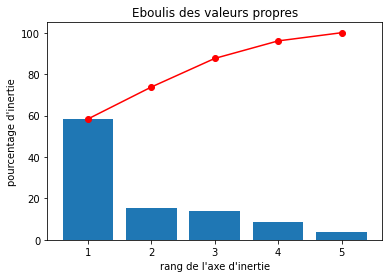

In [34]:
# Eboulis des valeurs propres
display_scree_plot(pca)


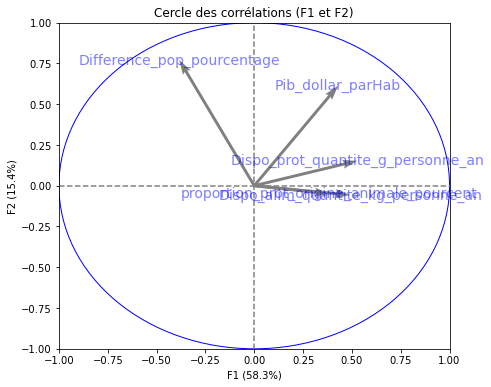

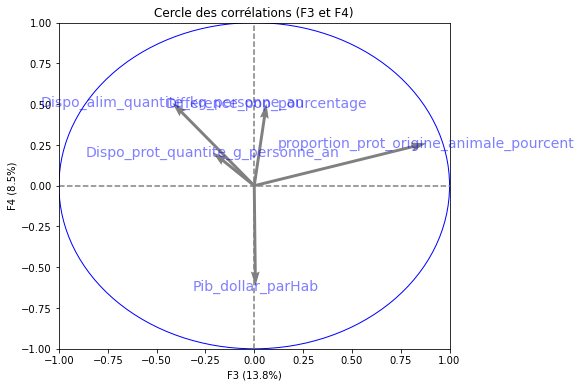

In [35]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

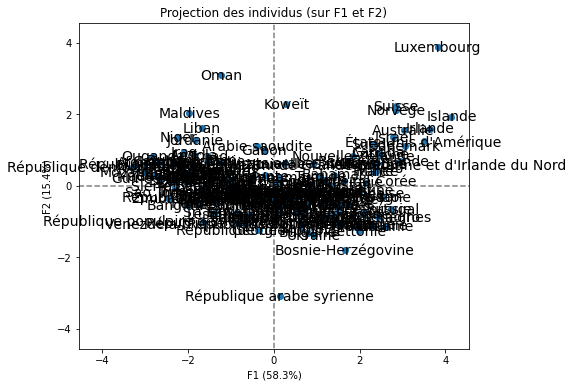

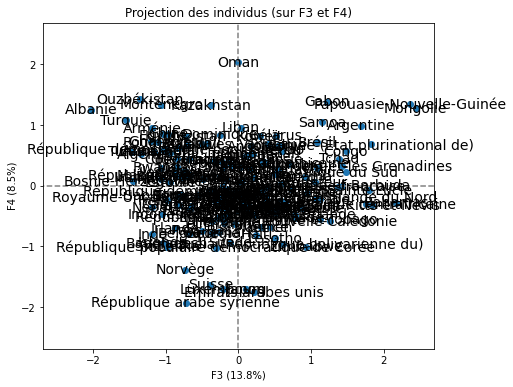

In [36]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))

plt.show()

On ne voit rien sur les 2 graphiques précédents à cause des noms des pays. Pour plus de clarté, on ne garde que les points.

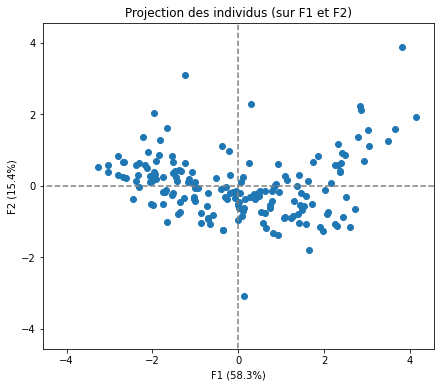

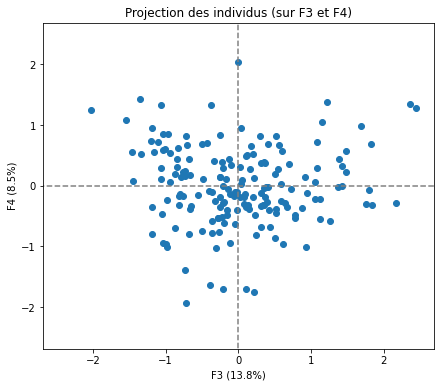

In [37]:
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)])

# Clustering hiérarchique

## Dendrogramme

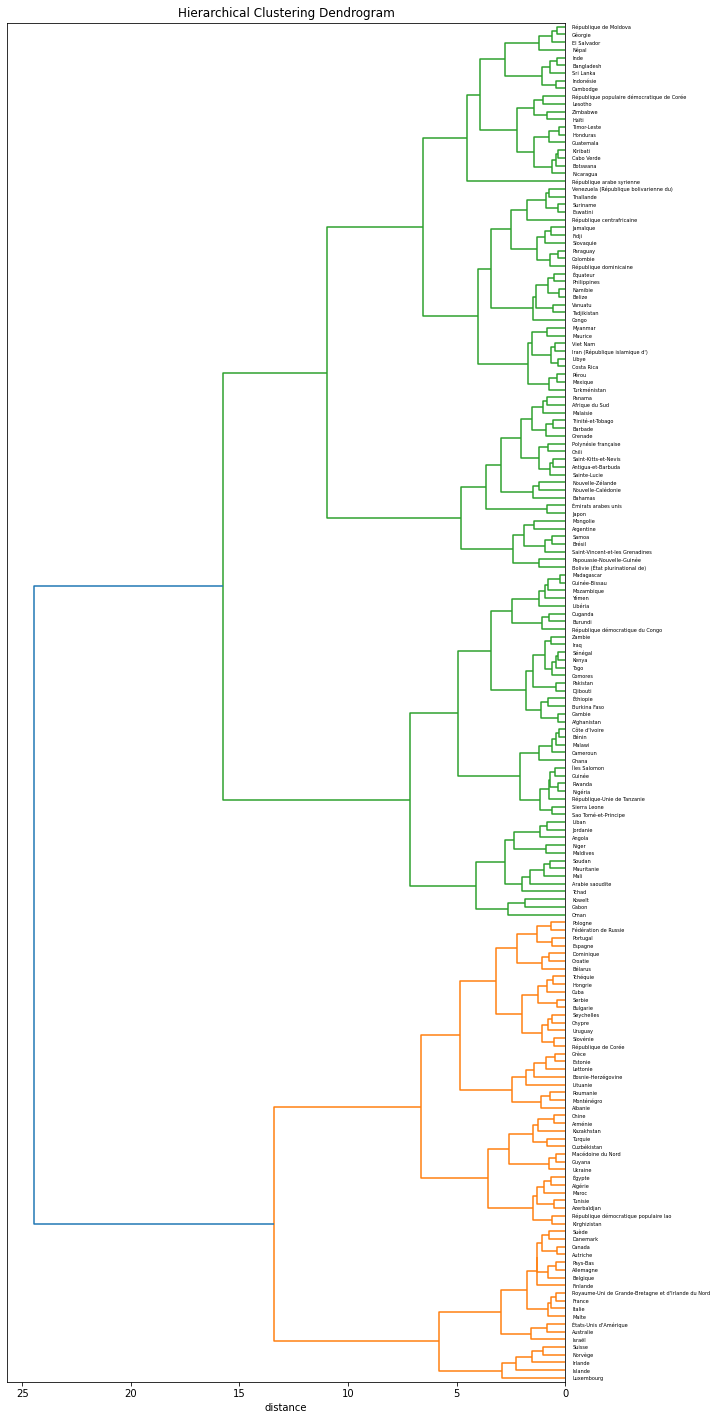

<Figure size 432x288 with 0 Axes>

In [38]:
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme

plt.figure(figsize=(10,25))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
dendrogram(
    Z,
    labels = names,
    orientation = "left",
)
plt.show()
plt.savefig('Dendrogram_le-retour.jpg')

## Kmeans

C:\Users\jb-14\AppData\Local\Temp/ipykernel_8384/4177431384.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)


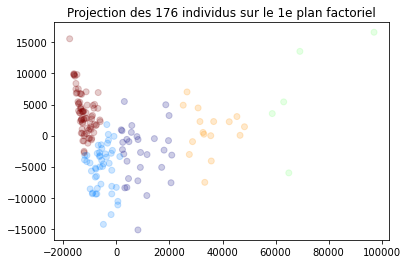

In [39]:
n_clust = 5

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

## Merge de nos clusters avec notre dataframe df_echantillon

In [40]:
# Coupage du dendrogramme en 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')
#clusters = fcluster(Z, 159, criterion='distance') # ligne équivalente à la précédente

# Comparaison des clusters trouvés avec les classification des cours en différents thèmes
cluster_pays = pd.DataFrame({
    #"theme": theme, 
    "cluster": clusters, "Zone": names})

cluster_pays = cluster_pays.sort_values(by='cluster')
cluster_pays
#print(courses.pivot_table(index="theme", columns="cluster", aggfunc=len, fill_value=0))

#clusters

,cluster,Zone
87,1,Luxembourg
72,1,Italie
71,1,Israël
70,1,Islande
69,1,Irlande
...,...,...
134,5,République populaire démocratique de Corée
65,5,Inde
34,5,Colombie
144,5,Slovaquie


In [41]:
df_echantillon_cluster = pd.merge(df_echantillon, cluster_pays, how='inner')
df_echantillon_cluster

,Zone,Dispo_prot_quantite_g_personne_an,Dispo_alim_quantite_kg_personne_an,Pib_dollar_parHab,Difference_pop_pourcentage,proportion_prot_origine_animale_pourcent,cluster
0,Afghanistan,21721.15,393.22,520.616409,16.477889,7.208872,3
1,Afrique du Sud,29083.20,531.35,6121.876572,7.906280,33.584337,4
2,Albanie,41858.20,1168.27,4514.204908,-1.026974,16.001046,2
3,Algérie,32335.35,747.87,4109.696001,10.713956,8.838469,2
4,Allemagne,37894.30,841.56,44651.829102,2.081915,26.045078,1
...,...,...,...,...,...,...,...
171,Émirats arabes unis,29981.10,482.08,40644.804043,3.780598,18.955442,4
172,Équateur,22907.40,577.10,6213.501276,8.473901,28.059273,5
173,États-Unis d'Amérique,41281.50,963.21,59921.674703,3.515710,35.826702,1
174,Éthiopie,26816.55,369.85,721.753494,14.745372,4.600517,3


## Isolation de notre cluster retenu

In [42]:
#on va faire un group by du dataframe sur les clusters. Mais si on fait ça on va perdre l'information 
#de chaque Zone. On va donc isoler les zones dans un premier temps, puis faire notre groupby.

df_echantillon_cluster_1 = df_echantillon_cluster.loc[df_echantillon_cluster['cluster'].isin([1]), :]
df_echantillon_cluster_2 = df_echantillon_cluster.loc[df_echantillon_cluster['cluster'].isin([2]), :]
df_echantillon_cluster_3 = df_echantillon_cluster.loc[df_echantillon_cluster['cluster'].isin([3]), :]
df_echantillon_cluster_4 = df_echantillon_cluster.loc[df_echantillon_cluster['cluster'].isin([4]), :]
df_echantillon_cluster_4 = df_echantillon_cluster.loc[df_echantillon_cluster['cluster'].isin([5]), :]

In [43]:
df_echantillon_cluster = df_echantillon_cluster.groupby(['cluster']).agg(['mean'])

In [44]:
df_echantillon_cluster.index=['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']
df_echantillon_cluster

,Dispo_prot_quantite_g_personne_an,Dispo_alim_quantite_kg_personne_an,Pib_dollar_parHab,Difference_pop_pourcentage,proportion_prot_origine_animale_pourcent
,mean,mean,mean,mean,mean
cluster_1,40468.097500,895.724500,55294.864618,4.068667,27.306541
cluster_2,35258.087500,874.526750,11124.584974,1.712292,22.137980
cluster_3,23198.588889,530.912222,3223.729525,15.914484,12.317784
cluster_4,31002.623913,634.447391,17044.147111,4.970637,35.045376
cluster_5,25134.660417,579.695625,4536.256004,5.468168,19.288454


### Fichier csv avec la liste des pays retenus

In [45]:
#on remarque que le pib ainsi que la consommation de protéines par rapport à la consommation de protéines totale est plus importante dans le cluster 1. On va donc orienter notre
#implémentation vers ces pays là. 

liste_pays = df_echantillon_cluster_1.copy()
liste_pays.to_csv('liste_pays.csv')
liste_pays

,Zone,Dispo_prot_quantite_g_personne_an,Dispo_alim_quantite_kg_personne_an,Pib_dollar_parHab,Difference_pop_pourcentage,proportion_prot_origine_animale_pourcent,cluster
4,Allemagne,37894.30,841.56,44651.829102,2.081915,26.045078,1
10,Australie,38923.60,893.89,57628.863849,7.337914,39.703676,1
11,Autriche,39190.05,878.69,47309.051637,3.736362,27.698612,1
16,Belgique,35890.45,825.53,44025.903247,3.016502,19.668463,1
30,Canada,38262.95,909.79,44906.748920,5.183161,29.304588,1
41,Danemark,42153.85,884.17,57938.797728,2.163128,27.682050,1
49,Finlande,43161.25,983.43,46385.550876,1.784028,22.790698,1
50,France,39890.85,863.35,38720.645922,2.011018,27.358404,1
69,Irlande,42099.10,1058.42,70568.302444,3.148324,25.273106,1
70,Islande,52990.70,933.03,73949.769216,2.684154,23.818708,1


In [46]:
liste_pays['Zone'].to_list()

['Allemagne',
 'Australie',
 'Autriche',
 'Belgique',
 'Canada',
 'Danemark',
 'Finlande',
 'France',
 'Irlande',
 'Islande',
 'Israël',
 'Italie',
 'Luxembourg',
 'Malte',
 'Norvège',
 'Pays-Bas',
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
 'Suisse',
 'Suède',
 "États-Unis d'Amérique"]

In [48]:
conda list

# packages in environment at C:\Users\jb-14\anaconda3:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2021.11                  py39_0  
_ipyw_jlab_nb_ext_conf    0.1.0            py39haa95532_0  
alabaster                 0.7.12             pyhd3eb1b0_0  
anaconda                  custom                   py39_1  
anaconda-client           1.9.0            py39haa95532_0  
anaconda-navigator        2.3.2            py39haa95532_0  
anaconda-project          0.10.1             pyhd3eb1b0_0  
anyio                     2.2.0            py39haa95532_2  
appdirs                   1.4.4              pyhd3eb1b0_0  
argh                      0.26.2           py39haa95532_0  
argon2-cffi               20.1.0           py39h2bbff1b_1  
arrow                     0.13.1           py39haa95532_0  
asn1crypto                1.4.0                      py_0  
astroid                   2.6.6            py39haa95532_0  
astropy                   4.3.1     

In [47]:
import matplotlib.pyplot as plt
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax2 = world.plot(figsize=(20,20), edgecolor=u'white', color='midnightblue')

countries = ['Germany',
 'Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Denmark',
 'Finland',
 'France',
 'Ireland',
 'Iceland',
 'Israel',
 'Italy',
 'Luxembourg',
 'Malta',
 'Norway',
 'The Netherlands',
 "United Kingdom of Great Britain and Northern Ireland",
 'Swiss',
 'Sweden',
 'United States of America']

world.loc[world['name'].isin(countries)].plot(edgecolor=u'white', color='gold', ax=ax2)

ax2.axis('scaled')
plt.show()

ModuleNotFoundError: No module named 'geopandas'

### Ficher CSV contenant les centroïdes des groupes et leurs coordonnées dans chacune des dimensions.

In [ ]:
# Affichage des positions des centres de classes
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

In [ ]:
centroids

In [ ]:
df_centroid = pd.DataFrame(centroids)
df_centroid.index=['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5']
df_centroid.to_csv('centroid.csv')
df_centroid

# Visualisation et test de loi normale

In [ ]:
%matplotlib inline
plt.hist(df_echantillon['Dispo_prot_quantite_g_personne_an'])
plt.title("histogramme")

fig, ax = plt.subplots()
n, bins, patches = ax.hist(df_echantillon['Dispo_prot_quantite_g_personne_an'],normed=True)
bins=numpy.arange(26,37,0.1)
y = mlab.normpdf(bins, xbar,sprime)*100
ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_title(u"Histogramme et densité normale")




In [ ]:
def test_loi_normale(df):
    mu, std = norm.fit(df) 
    
    # Plot the histogram.
    plt.hist(df, bins=25, density=True, alpha=0.6, color='b')
    
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()

In [ ]:
test_loi_normale(df_echantillon['Dispo_alim_quantite_kg_personne_an'])

In [ ]:
test_loi_normale(df_echantillon['Dispo_prot_quantite_g_personne_an'])

In [ ]:
test_loi_normale(df_echantillon['Difference_pop_pourcentage'])

In [ ]:
test_loi_normale(df_echantillon['Difference_pop_pourcentage'])

In [ ]:
test_loi_normale(df_echantillon['proportion_prot_origine_animale_pourcent'])

In [ ]:
test_loi_normale(df_echantillon['Pib_dollar_parHab'])

In [ ]:
#faire une anova entre cette variable et les cluster

In [ ]:
sp.stats.shapiro(df_echantillon['Dispo_prot_quantite_g_personne_an'])

La p-value = 0.34 est plus grande que 0.05, donc on ne peut pas rejeter l'hyptohèse nulle. Nous n'avons pas de preuves suffisantes pour dire que l'échantillon ne provient pas d'une distribution normale.

On peut donc en déduire que la disponibilité en protéine en g/personne/an suit une loi normale.

In [ ]:
sp.stats.shapiro(df_echantillon['proportion_prot_origine_animale_pourcent'])

In [ ]:
print(sp.stats.pearsonr(df_echantillon['Dispo_prot_quantite_g_personne_an'],df_echantillon['Pib_dollar_parHab'])[0])
print(np.cov(df_echantillon['Dispo_prot_quantite_g_personne_an'],df_echantillon['Pib_dollar_parHab'],ddof=0)[1,0])

Donc on a bien une corrélation entre la disponibilité en protéine en g/personne/an et le PIB en dollar/hab

# Test de comparaison de deux populations (dans le cas gaussien)

In [ ]:
#Comparaison cluster 1 et 2

https://s3-eu-west-1.amazonaws.com/course.oc-static.com/courses/4525306/python_statistiques_inferentielles.html

In [ ]:
#test de l’égalité des variances

sp.stats.bartlett(df_echantillon_cluster_1['Dispo_prot_quantite_g_personne_an'],df_echantillon_cluster_2['Dispo_prot_quantite_g_personne_an'])

La p-valeur valant 0.86, on ne rejette donc pas l’égalité des variances au niveau de test 5%.

In [ ]:
#test de l’égalité des moyennes
sp.stats.ttest_ind(df_echantillon_cluster_1['Dispo_prot_quantite_g_personne_an'],df_echantillon_cluster_2['Dispo_prot_quantite_g_personne_an'], equal_var=True)

On obtient une p-valeur égale à environ 1.3×10−05. On constate donc que l’hypothèse d’égalité des disponibilités en protéine en g/personne/an est rejetée à un niveau de test de 5%. On rejette que les disponibilités en protéine en g/personne/an suivent la même distribution, et donc on rejette l’hypothèse d’égalité des moyennes.

In [ ]:
#Test de shapiro sur les 2 dataframes
sp.stats.shapiro(df_echantillon_cluster_1['Dispo_prot_quantite_g_personne_an'])


In [ ]:
sp.stats.shapiro(df_echantillon_cluster_2['Dispo_prot_quantite_g_personne_an'])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1ee07386-aa80-48b6-a794-cb2a65040702' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>